# Modelo de red neuronal convolucional base (35 capas)

En este notebook construiremos un modelo de red neuronal convolucional con 35 capas entrenables, inspirado en la arquitectura ResNet-50, pero sin conexiones residuales. Los detalles del entrenamiento y de los datos pueden ser consultados en el notebook "./ResNet-50.ipynb".

### Preparación de los datos

In [1]:
# Importamos las paqueterías necesarias para el notebook
import time
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

# De ser posible utilizaremos GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def data_loader(data_dir,
                batch_size,
                random_seed=42,
                valid_size=0.1,
                shuffle=False,
                test=False):
    """
    Función para cargar los datos de CIFAR-10
    """
    
    # Definimos el transform para normalizar los datos con pytorch
    # Los valores fueron obtenidos en el notebook "data_extraction.ipynb"
    normalize = transforms.Normalize(  
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # Definimos el transform para preporcesar los datos
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])
    
    # Obtener los datos del conjunto de prueba
    if test:
        dataset = datasets.CIFAR10(
          root=data_dir, train=False,
          download=True, transform=transform_test,
        )

        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle
        )

        return data_loader

    # Cargamos una copia de los datos de entrenamiento
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform_train,
    )
    
    # Cargamos una copia extra de los datos de entrenamiento para dividirlo después en el conjunto de validación
    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform_train,
    )
    
    # Separamos los datos de entrenamiento y validación mediante índices
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(42)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # Finalmente, definimos los conjuntos de entrenamiento y validación
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


# Aplicamos la función para cargar los datos de CIFAR-10, los guardamos en el directorio actual
train_loader, valid_loader = data_loader(data_dir='./data',
                                         batch_size=64)

test_loader = data_loader(data_dir='./data',
                              batch_size=64,
                              test=True)    
cifar10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Definición del modelo

La estructura del modelo es la misma que ResNet-50, sin conexiones residuales y con stages de 2,3,4,2 bloques Bottleneck respectivamente. Como el modelo empieza con una capa convolucional, cada bloque Bottleneck tiene 3 capas convolucionales y el modelo termina con una capa lineal, este modelo tiene un total de 1+(2+3+4+2)\*3+1=35 capas entrenables

In [3]:
class utilConv(nn.Sequential):
    def __init__(self, in_features, out_features, kernel_size, stride = 1, norm = nn.BatchNorm2d, act = nn.ReLU, bias=True):
        super().__init__(
            nn.Conv2d(in_features, out_features, kernel_size=kernel_size ,padding=kernel_size // 2, stride=stride, bias=bias),
            norm(out_features),
            act()
        )

class BottleNeckBlock(nn.Module):
    def __init__(self,in_features, out_features, reduction = 4, stride = 1):
        super().__init__()
        reduced_features = out_features // reduction
        self.block = nn.Sequential(
            # Reducción de canales
            utilConv(in_features, reduced_features, kernel_size=1, stride=stride, bias=False), # el stride puede ser 2 para aplicar downsampling
            # El número de canales se mantiene fijo
            utilConv(reduced_features, reduced_features, kernel_size=3, bias=False),
            # Aumento de canales
            utilConv(reduced_features, out_features, kernel_size=1, bias=False), 
        )

    def forward(self, x):
        x = self.block(x)
        return x

In [4]:
class ConvNet_35_capas(nn.Module):
    """
    Modelo de red neuronal convolucional de 35 capas para clasificar imágenes en 10 clases posibles
    """
    def __init__(self):
        super().__init__()
        self.conv1 = utilConv(3,64,kernel_size=3)
        
        self.bloc1 = nn.Sequential(BottleNeckBlock(64,64,stride=1),
                                   *[BottleNeckBlock(64,64) for _ in range(2-1)])
        
        self.bloc2 = nn.Sequential(BottleNeckBlock(64, 128, stride=2),
                                   *[BottleNeckBlock(128,128) for _ in range(3-1)])
        
        self.bloc3 = nn.Sequential(BottleNeckBlock(128,256,stride=2),
                                   *[BottleNeckBlock(256,256) for _ in range(4-1)])
   
        self.bloc4 = nn.Sequential(BottleNeckBlock(256,512,stride=2),
                                   *[BottleNeckBlock(512,512) for _ in range(2-1)])
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512,10)
        
    def forward(self,x):
        out = self.conv1(x)
        out = self.bloc1(out)
        out = self.bloc2(out)
        out = self.bloc3(out)
        out = self.bloc4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = F.softmax(out, dim = 1)
        return out

### Entrenamiento

In [5]:
def entrenamiento():
    # variables para guardar los resultados
    accuracy_training_epochs = []
    accuracy_validation_epochs = []
    loss_epoch = []
    test_accuracy = []
    
    # hiperparámetros
    num_epochs = 90

    model = ConvNet_35_capas().to(device)

    optimizer = optim.SGD(
            params=model.parameters(),
            lr=0.1,
            momentum=0.9,
            weight_decay=0.0001)
    
    criterion = nn.CrossEntropyLoss()
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=60, gamma=0.1)

    # lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=120)
    
    # entrenamiento
    for epoch in range(num_epochs):
        start_time = time.time()
        for i, (images, labels) in enumerate(train_loader):

            # Mover a los tensores a GPU de ser posible
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass y descenso de gradiente estocástico
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Ahorro de memoria
            del images, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()

        loss_epoch.append(loss.item())
        lr_scheduler.step() # Implementación de learning rate decay

        # Exactitud en el conjunto de validación
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del images, labels, outputs
            val_accuracy = correct/total
            accuracy_validation_epochs.append(val_accuracy)

        # Exactitud en el total del conjunto de entrenamiento
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del images, labels, outputs
            train_accuracy = correct/total
            accuracy_training_epochs.append(train_accuracy)

        # Exactitud en el conjunto de prueba
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del images, labels, outputs
            t_acc = correct/total
            test_accuracy.append(t_acc)



        print(f"Epoch [{epoch+1}/{num_epochs}], Training accuracy: {round(train_accuracy,3)}, Validation accuracy: {round(val_accuracy,3)}, loss = {round(loss_epoch[-1],3)}")
        print(f"Time spent on epoch {epoch+1}: {round((time.time()-start_time)/60,2)}min")
        
    return [model,
            accuracy_training_epochs,
            accuracy_validation_epochs,
            test_accuracy,
            loss_epoch]  # model, training accuracy, validation accuracy, test accuracy, loss

In [6]:
# repetimos 3 veces el experimento
model1, training1, validation1, test1, loss1 = entrenamiento()
model2, training2, validation2, test2, loss2 = entrenamiento()
model3, training3, validation3, test3, loss3 = entrenamiento()

Epoch [1/90], Training accuracy: 0.238, Validation accuracy: 0.239, loss = 2.153
Time spent on epoch 1: 2.92min
Epoch [2/90], Training accuracy: 0.238, Validation accuracy: 0.242, loss = 2.275
Time spent on epoch 2: 2.92min
Epoch [3/90], Training accuracy: 0.282, Validation accuracy: 0.283, loss = 2.072
Time spent on epoch 3: 2.94min
Epoch [4/90], Training accuracy: 0.325, Validation accuracy: 0.324, loss = 2.125
Time spent on epoch 4: 2.94min
Epoch [5/90], Training accuracy: 0.339, Validation accuracy: 0.343, loss = 1.95
Time spent on epoch 5: 2.96min
Epoch [6/90], Training accuracy: 0.348, Validation accuracy: 0.347, loss = 2.037
Time spent on epoch 6: 2.96min
Epoch [7/90], Training accuracy: 0.351, Validation accuracy: 0.369, loss = 2.247
Time spent on epoch 7: 2.98min
Epoch [8/90], Training accuracy: 0.361, Validation accuracy: 0.371, loss = 2.094
Time spent on epoch 8: 2.99min
Epoch [9/90], Training accuracy: 0.339, Validation accuracy: 0.337, loss = 2.308
Time spent on epoch 9: 2

Epoch [74/90], Training accuracy: 0.67, Validation accuracy: 0.658, loss = 1.705
Time spent on epoch 74: 2.99min
Epoch [75/90], Training accuracy: 0.671, Validation accuracy: 0.659, loss = 1.933
Time spent on epoch 75: 3.0min
Epoch [76/90], Training accuracy: 0.673, Validation accuracy: 0.663, loss = 1.818
Time spent on epoch 76: 3.0min
Epoch [77/90], Training accuracy: 0.674, Validation accuracy: 0.663, loss = 1.816
Time spent on epoch 77: 3.0min
Epoch [78/90], Training accuracy: 0.679, Validation accuracy: 0.653, loss = 1.873
Time spent on epoch 78: 3.0min
Epoch [79/90], Training accuracy: 0.676, Validation accuracy: 0.667, loss = 2.07
Time spent on epoch 79: 3.0min
Epoch [80/90], Training accuracy: 0.678, Validation accuracy: 0.67, loss = 1.72
Time spent on epoch 80: 3.0min
Epoch [81/90], Training accuracy: 0.686, Validation accuracy: 0.677, loss = 1.813
Time spent on epoch 81: 3.0min
Epoch [82/90], Training accuracy: 0.676, Validation accuracy: 0.661, loss = 1.981
Time spent on epo

Epoch [57/90], Training accuracy: 0.538, Validation accuracy: 0.54, loss = 2.01
Time spent on epoch 57: 3.0min
Epoch [58/90], Training accuracy: 0.537, Validation accuracy: 0.532, loss = 1.778
Time spent on epoch 58: 3.01min
Epoch [59/90], Training accuracy: 0.539, Validation accuracy: 0.541, loss = 2.028
Time spent on epoch 59: 3.01min
Epoch [60/90], Training accuracy: 0.554, Validation accuracy: 0.556, loss = 1.846
Time spent on epoch 60: 3.02min
Epoch [61/90], Training accuracy: 0.605, Validation accuracy: 0.599, loss = 1.997
Time spent on epoch 61: 3.01min
Epoch [62/90], Training accuracy: 0.614, Validation accuracy: 0.609, loss = 1.74
Time spent on epoch 62: 3.0min
Epoch [63/90], Training accuracy: 0.619, Validation accuracy: 0.623, loss = 2.099
Time spent on epoch 63: 3.01min
Epoch [64/90], Training accuracy: 0.624, Validation accuracy: 0.617, loss = 1.857
Time spent on epoch 64: 3.01min
Epoch [65/90], Training accuracy: 0.627, Validation accuracy: 0.618, loss = 1.964
Time spent 

Epoch [40/90], Training accuracy: 0.493, Validation accuracy: 0.489, loss = 1.976
Time spent on epoch 40: 3.02min
Epoch [41/90], Training accuracy: 0.507, Validation accuracy: 0.509, loss = 1.832
Time spent on epoch 41: 3.01min
Epoch [42/90], Training accuracy: 0.505, Validation accuracy: 0.504, loss = 2.027
Time spent on epoch 42: 3.01min
Epoch [43/90], Training accuracy: 0.527, Validation accuracy: 0.521, loss = 2.188
Time spent on epoch 43: 3.01min
Epoch [44/90], Training accuracy: 0.518, Validation accuracy: 0.511, loss = 2.002
Time spent on epoch 44: 3.0min
Epoch [45/90], Training accuracy: 0.526, Validation accuracy: 0.523, loss = 2.098
Time spent on epoch 45: 3.01min
Epoch [46/90], Training accuracy: 0.521, Validation accuracy: 0.515, loss = 1.832
Time spent on epoch 46: 3.01min
Epoch [47/90], Training accuracy: 0.533, Validation accuracy: 0.531, loss = 2.046
Time spent on epoch 47: 3.0min
Epoch [48/90], Training accuracy: 0.534, Validation accuracy: 0.534, loss = 2.085
Time spe

In [7]:
# guardar uno de los modelos
torch.save(model1,"./model_ConvNet-35.pt")

### Resultados

In [8]:
# Guardar en csv
results_dict1 = {"loss": loss1,
    'Train':training1,
     'Validation': validation1,
     "Test":test1}
results_dict2 = {"loss": loss2,
    'Train':training2,
     'Validation': validation2,
     "Test":test2}
results_dict3 = {"loss": loss3,
    'Train':training3,
     'Validation': validation3,
     "Test":test3}

pd.DataFrame(results_dict1).to_csv("./results/results_ConvNet35_1.csv",index=False)
pd.DataFrame(results_dict2).to_csv("./results/results_ConvNet35_2.csv",index=False)
pd.DataFrame(results_dict3).to_csv("./results/results_ConvNet35_3.csv",index=False)

In [9]:
results1 = pd.DataFrame(results_dict1)
results2 = pd.DataFrame(results_dict2)
results3 = pd.DataFrame(results_dict3)

In [10]:
# Accuracy 
accuracy = (results1["Test"].max() + results2["Test"].max() + results3["Test"].max())/3
print(accuracy)

0.6642333333333333


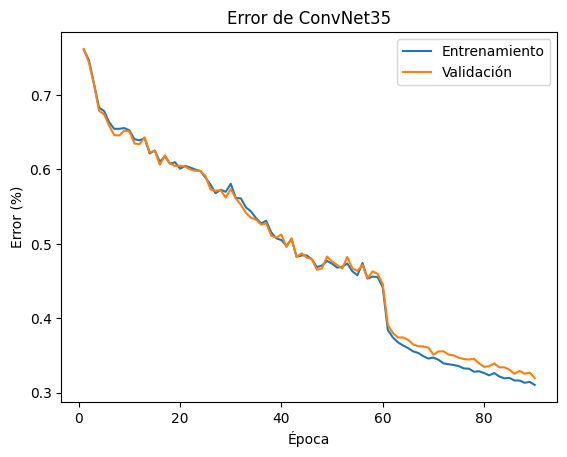

In [13]:
# graficar resultados
x_axis = np.arange(90)+1
validation_err = 1- (np.array(validation1) + np.array(validation2) + np.array(validation3) )/3
train_err = 1- (np.array(training1)+np.array(training2)+np.array(training3))/3

plt.plot(x_axis, train_err)
plt.plot(x_axis, validation_err)
# plt.plot(x_axis, np.ones(90)*0.5, 'k--', linewidth = 0.5)
plt.title("Error de ConvNet35")
plt.ylabel('Error (%)')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.show()
plt.close()

In [12]:
# Fin